In [54]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [55]:
df = pd.read_csv(r'C:\Users\ashbat\Desktop\totalByWeekWHCitrus.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'W-MON'

In [56]:
df.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,313.47014,0
2016-03-21,397.83376,13
2016-03-28,535.69880,0
2016-04-04,640.74398,0
2016-04-11,718.47232,0


In [57]:
print(df.index.freq)

<Week: weekday=0>


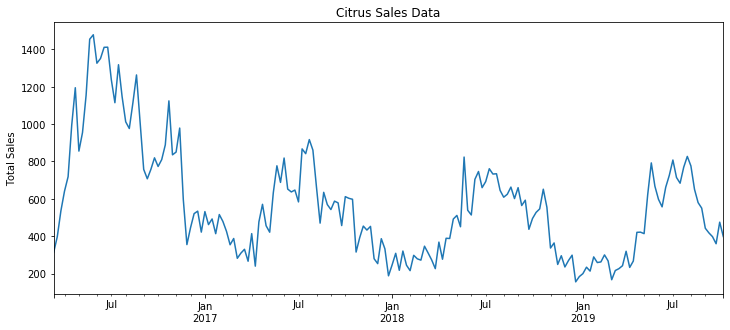

In [58]:
title='Citrus Sales Data'
ylabel='Total Sales'
xlabel='' 

ax = df['TOTAL_PRICESELL'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

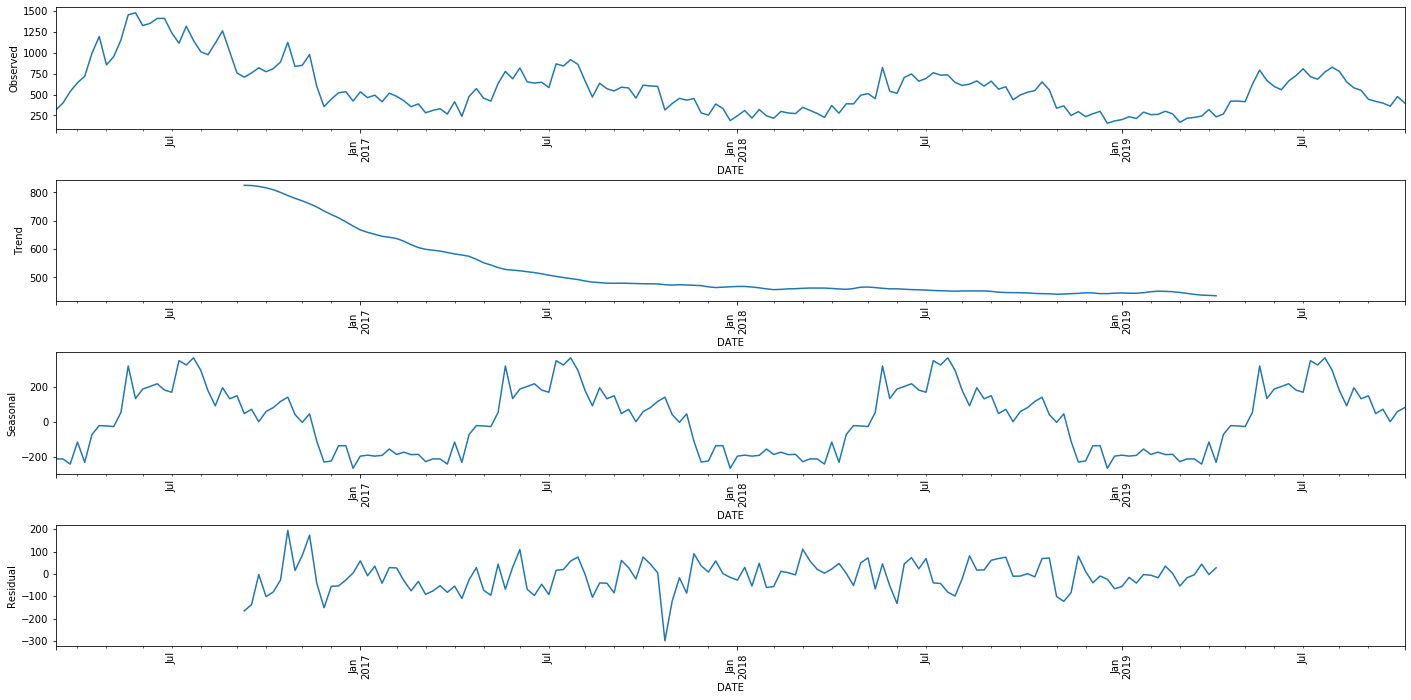

In [59]:
result = seasonal_decompose(df['TOTAL_PRICESELL'], model='add')

observed = result.observed
trend = result.trend
seasonal =  result.seasonal
residual =  result.resid

decomp_data = pd.DataFrame({"Observed":observed, "Trend": trend, "Seasonal":seasonal,"Residual":residual})

import matplotlib.pyplot as plt

figure, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10))
figure.tight_layout(pad=3.0)
for i, ax in enumerate(axes):
    ax = decomp_data.iloc[:,i].plot(ax=ax)
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)
#     ax.xaxis.set_minor_locator(months)
#     ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(decomp_data.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

figure.savefig('citrus_decomp.png')

In [60]:
#auto_arima(df['TOTAL_PRICESELL'],seasonal=True,m=52).summary()

In [61]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [62]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -839.847
Date:                            Sun, 17 May 2020   AIC                           1687.694
Time:                                    11:52:28   BIC                           1699.286
Sample:                                03-14-2016   HQIC                          1692.405
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2396      0.066     -3.636      0.000      -0.369      -0.110
ar.S.L52       0.8440      0.852      0.991      0.322      -0.826       2.514
ma.S.L52      -0.6960      1.073     -0.649      0.516      -2.799       1.407
sigma2      1.555e+04   3246.673      4.788      0.000    9181.889    2.19e+04
===================================================================================
Ljung-Box (Q):                       44.19   Jarque-Bera (JB):                 2.46
Prob(Q):                              0.30   Prob(JB):                         0.29
Heteroskedasticity (H):               0.31   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

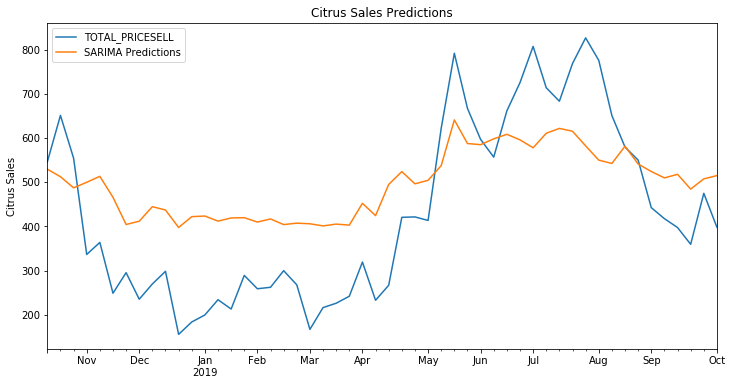

In [64]:
#Compare to validation data
title='Citrus Sales Predictions'
ylabel='Citrus Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [65]:
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMA MSE: {error1:11.10}')
print(f'SARIMA RMSE: {error2:11.10}')

SARIMA MSE: 22293.98508
SARIMA RMSE: 149.3117044


In [66]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA Forecast')

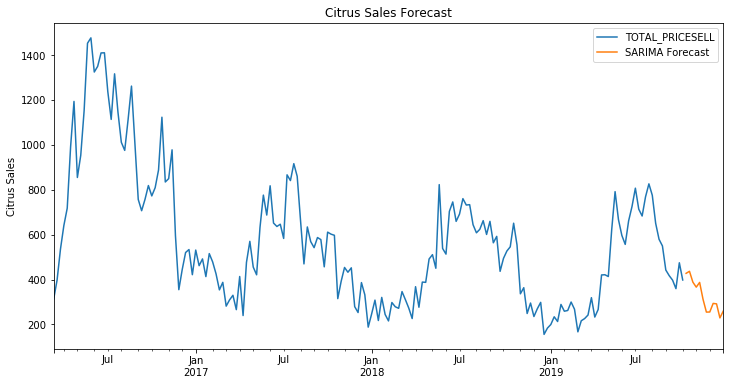

In [67]:
title='Citrus Sales Forecast'
ylabel='Citrus Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [68]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [69]:
train.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,313.47014,0
2016-03-21,397.83376,13
2016-03-28,535.69880,0
2016-04-04,640.74398,0
2016-04-11,718.47232,0


In [70]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],exog=train['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -839.570
Date:                            Sun, 17 May 2020   AIC                           1689.140
Time:                                    11:52:54   BIC                           1703.629
Sample:                                03-14-2016   HQIC                          1695.028
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
holidayWeekS    -1.1003      1.668     -0.660      0.509      -4.369       2.168
ma.L1           -0.2288      0.066     -3.463      0.001      -0.358      -0.099
ar.S.L52         0.8465      0.869      0.974      0.330      -0.857       2.550
ma.S.L52        -0.7007      1.095     -0.640      0.522      -2.847       1.446
sigma2        1.549e+04   3289.826      4.707      0.000    9038.876    2.19e+04
===================================================================================
Ljung-Box (Q):                       46.68   Jarque-Bera (JB):                 2.71
Prob(Q):                              0.22   Prob(JB):                         0.26
Heteroskedasticity (H):               0.32   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holidayWeekS']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMAX MSE: {error1:11.10}')
print(f'SARIMAX RMSE: {error2:11.10}')

SARIMAX MSE: 22185.47935
SARIMAX RMSE: 148.9479082


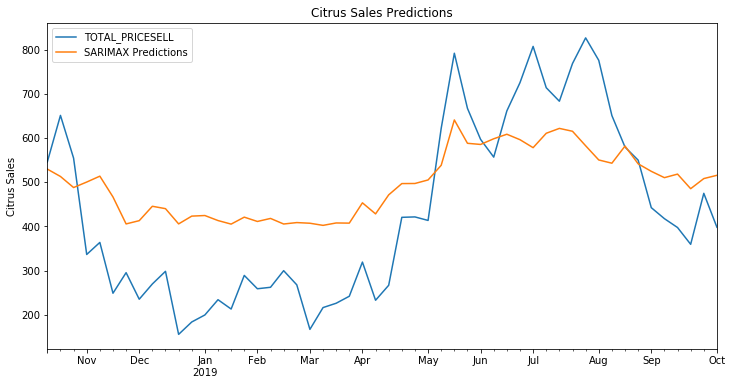

In [72]:
#Compare to validation data
title='Citrus Sales Predictions'
ylabel='Citrus Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [73]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],exog=df['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()

In [74]:
start=len(df)
end=len(df) + 11
exog_forecast = pd.read_csv(r'C:\Users\ashbat\Desktop\ExogHolidays.csv',index_col='DATE',parse_dates=True)
exog_forecast.index.freq = 'W-MON'
exog_forecast = exog_forecast[['holidayWeekS']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')

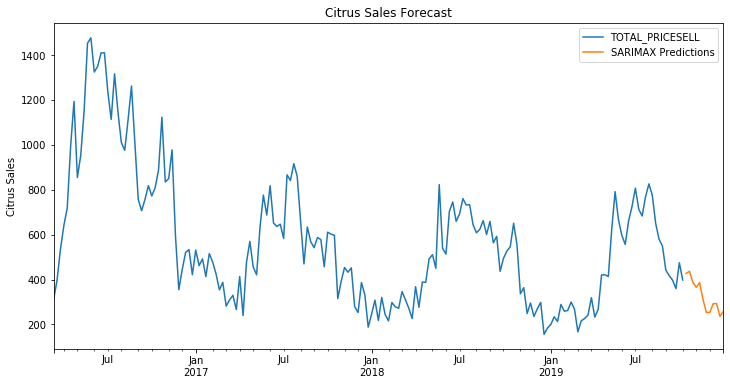

In [76]:
title='Citrus Sales Forecast'
ylabel='Citrus Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);